In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

def plot_confusion_matrix(ytrue, yhat):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    labels = ['admission', 'no admission']
    result = confusion_matrix(ytrue, yhat)
    fig = plt.figure(figsize=(8,6))
    ax = sns.heatmap(result, annot=True, cmap=cmap)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()

def categorial_to_numerical(df, cols):
    for col in cols:
        tmp= pd.get_dummies(df[col], prefix=col)
        df = df.join(tmp)
    return df.drop(columns=cols)

In [7]:
df_admission = pd.read_csv('admissions.csv')
df_score = pd.read_csv('scores.csv')
df_member = pd.read_csv('members.csv')

df_admission_count = pd.DataFrame(df_admission.id.value_counts()).reset_index()
df_admission_count.columns = ['id', 'counts']

df = df_member.merge(df_score, on='id', how='left').merge(df_admission_count, on='id', how='left')
df.counts = df.counts.fillna(0)
df = shuffle(df)

cat_cols = ['gender', 'race']
df = categorial_to_numerical(df, cat_cols)

df['admission'] = df.counts.apply(lambda x: True if x!=0 else False)

cols_to_drop = ['dob', 'zip_code', 'name', 'counts', 'id']
df = df.drop(columns=cols_to_drop)

# just save 1/5 of the original data, and start from there
df_admission_true = df[df.admission==True]
df_admission_false = df[df.admission==False]

n = int(0.2*df_admission_true.shape[0])

all_idx = np.arange(df_admission_true.shape[0])
np.random.shuffle(all_idx)
idx_test = all_idx[:n]
df_admission_true_test = df_admission_true.iloc[idx_test, :]

all_idx = np.arange(df_admission_false.shape[0])
np.random.shuffle(all_idx)
idx_test = all_idx[:n]
df_admission_false_test = df_admission_false.iloc[idx_test, :]

df_test = pd.concat([df_admission_false_test, df_admission_true_test], axis=0)

df_train = df.loc[~df.index.isin(df_test.index), :]

# CFO: who is likely to be admitted
As the CFO I would like to be able to predict which members are likely to be admitted
into the hospital, this would allow us to prioritize outreach to those members and
support them in the home in order to avoid future hospital stays.

In [17]:
df_admission_true = df_train[df_train.admission==True]
df_admission_false = df_train[df_train.admission==False]
df_admission_false = shuffle(df_admission_false)

params = {
    'max_depth': 3,
    'learning_rate': 0.04,
    'booster': 'gbtree',
    'n_estimator': 1000
}

cv = 5
to_test = 0.2
true_len = df_admission_true.shape[0]
results = pd.DataFrame(index=list(range(cv)), columns=['accuracy', 'precision', 'recall'])
trained_model = []
for i in range(cv):
    df_admission_false_resampled = df_admission_false[i*true_len:(i+1)*true_len]
    df_train_resampled = pd.concat([df_admission_true, df_admission_false_resampled], axis=0)
    df_train_resampled = shuffle(df_train_resampled)
    dftrain = df_train_resampled[:int((1-to_test)*len(df_train_resampled))]
    dftest = df_train_resampled[int((1-to_test)*len(df_train_resampled)):]
    ytrain = dftrain['admission']
    Xtrain = dftrain.drop(columns=['admission'])
    ytest = dftest['admission']
    Xtest = dftest.drop(columns=['admission'])
    
    transformer = StandardScaler()
    transformer.fit(Xtrain)
    Xtrain = transformer.transform(Xtrain)
    
    xgb = XGBClassifier(**params)
    xgb.fit(Xtrain, ytrain)
    Xtest = transformer.transform(Xtest)
    yhat = xgb.predict(Xtest)
    
    results.loc[i, 'accuracy'] = accuracy_score(ytest, yhat)
    results.loc[i, 'precision'] = precision_score(ytest, yhat)
    results.loc[i, 'recall'] = recall_score(ytest, yhat)
    
    trained_model.append([transformer, xgb])

In [19]:
results

,accuracy,precision,recall
0,0.817961,0.780612,0.827027
1,0.878641,0.891192,0.855721
2,0.868932,0.895522,0.84507
3,0.878641,0.876923,0.86802
4,0.868932,0.84,0.884211


In [20]:
ytest = df_test['admission']
Xtest = df_test.drop(columns=['admission'])

Xtest = trained_model[3][0].transform(Xtest)

yhat = trained_model[3][1].predict(Xtest)

accuracy_score(ytest, yhat)

0.8793774319066148

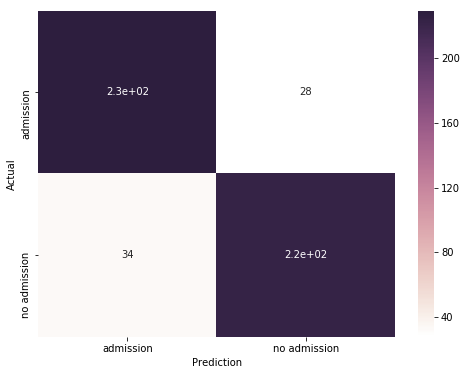

In [21]:
plot_confusion_matrix(ytest, yhat)

# VP of Life Management: what factor contributes to admission
As the VP of Life Management I to understand what factors contribute to hospital
admissions, this would help our life managers understand our members more deeply
and provide personal care plans for each member.

In [183]:
sorted_idx = np.argsort(xgb.feature_importances_)

In [184]:
sorted_col = [feature_cols[i] for i in sorted_idx]
sorted_feature_importance = [xgb.feature_importances_[i] for i in sorted_idx]

<BarContainer object of 17 artists>

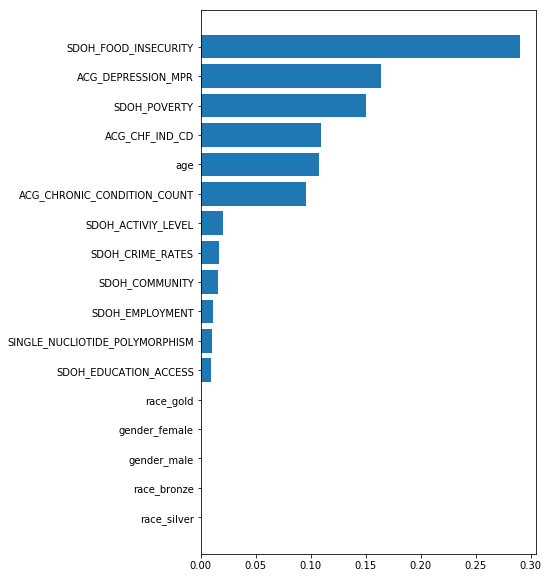

In [185]:
plt.figure(figsize=(6,10))
plt.barh(sorted_col, sorted_feature_importance)

# VP of Life Management: what characteristics of people with high admission rate 
I would like to understand the members that have the
most hospital admissions.

In [193]:
df = df_member.merge(df_score, on='id', how='left').merge(df_admission_count, on='id', how='left')
df_admission_true_all = df[~df.counts.isnull()]

In [212]:
max_count = max(df_admission_true_all.counts)
df_admission_max = df_admission_true_all[df_admission_true_all.counts>=max(df_admission_true_all.counts)-4]
df_admission_others = df_admission_true_all[df_admission_true_all.counts<max(df_admission_true_all.counts)-4]

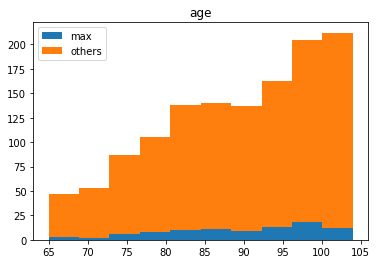

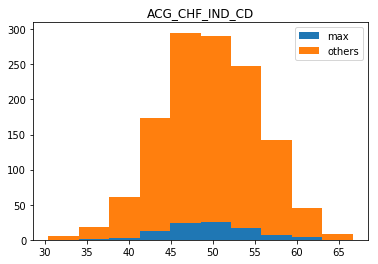

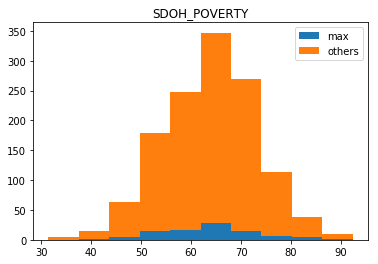

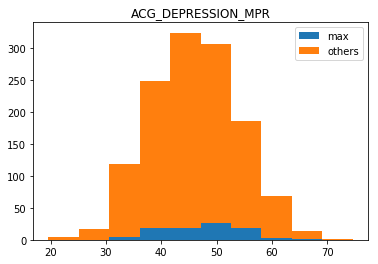

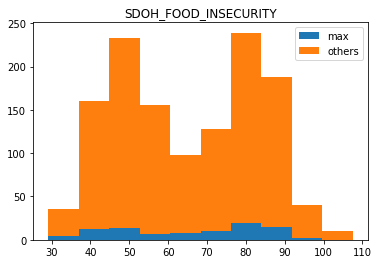

In [214]:
for col in sorted_col[-5:]:
    plt.hist([df_admission_max[col],df_admission_others[col]], label=['max','others'], stacked=True)
    plt.title(col)
    plt.legend()
    plt.show()